In [1]:
#this uses iPython magic to make plots appear inline
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import sys
import numpy as np
import matplotlib.patches as patches
import glob
import gzip
import fileinput
import time
import datetime

def count_lines(f):
    lineCount = 0
    with open(f, 'r') as f:
        for line in f:
            lineCount += 1
        return lineCount
def runCMD(cmd):
    val = subprocess.Popen(cmd, shell=True).wait()
    if val == 0:
        pass
    else:
        print ('command failed')
        print (cmd)
        sys.exit(1)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

In [2]:
def get_chrom_sizes():
    chromSizefile = '/home/ampend/links/kidd-lab/www-mirror/www/track-hub/canFam3/canFam3.1-browser-chrom-sizes.fai'
    print ('Reading in chromosome lengths from: ', chromSizefile)
    chromSizeFile = open(chromSizefile, 'r')

    chromSizeList,chromlist = {},[]
    #I also need a list of chr and position for finding the index for windows 
    for line in chromSizeFile:
        if "chrUn" in line: #ignore chromsome unknowns 
            continue
        if "chrM" in line: #ignore mito
            continue

        line = line.rstrip()
        line = line.split()

        chromID = line[0] #chromosome ID
        chromlist.append(chromID)
        chromLength = int(line[1]) #length of chromosome
        chromSizeList[chromID] = chromLength

    return chromSizeList, chromlist
#####################################################################################################

In [3]:
wkDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Simulations/'

#Getting chromosome sizes
chromSizeList,chromlist = get_chrom_sizes()

#simulationRound = 4


Reading in chromosome lengths from:  /home/ampend/links/kidd-lab/www-mirror/www/track-hub/canFam3/canFam3.1-browser-chrom-sizes.fai


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

In [4]:
#Only needs to be done once new data has been generated
#Combining the VCF frq.count files into whole genome files for simulations 0-9
for sim in range(0,2): #for simulations 0-9
    #for wolves
    cmd = 'cat %sinput/simulation%i/wolf_chr*.%i.simulation.recode.frq.count > %sinput/simulation%i/wolf_%i.simulation.recode.frq.count' % (wkDir,simulationRound,sim,wkDir,simulationRound,sim)
    runCMD(cmd)
    #for village dogs
    cmd = 'cat %sinput/simulation%i/dog_chr*.%i.simulation.recode.frq.count > %sinput/simulation%i/dog_%i.simulation.recode.frq.count' % (wkDir,simulationRound,sim,wkDir,simulationRound,sim)
    runCMD(cmd)
print('DONE merging the dog and wolf frq.count files within simulation')

NameError: name 'simulationRound' is not defined

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

In [5]:
def get_chr_pos(infile):
    chr_pos = []
    for line in open(infile,'r'):
        if line[0] == 'C':
            continue 
        line = line.rstrip() #removing extraneous whitespace characters
        line = line.split() #delimiting "columns" in the file based on tabs		
        if len(chromlist) == 0 or line[0] != chromlist[-1]:
            chromlist.append(line[0])
        chr_pos.append(line) #I dont want to append the whole line I just need chr and pos...
    return chr_pos
#####################################################################################################
def process_inputlines(line):
    line = line.rstrip() #removing extraneous whitespace characters
    line = line.split() #delimiting "columns" in the file based on tabs
    line[4] = float(line[4].split(':')[-1])
    line[5] = float(line[5].split(':')[-1])
    return line[4],line[5] 
#####################################################################################################
#####################################################################
# PER JEFF:
# Calculates estimate of 2 pop Fst using Hudson's estimator
# as described in Bhatia et al 2013
# input is [a1_count,a2_count][a1_counts,a2_count]
# returns (fst,numerator,denominator) for use in taking ratio of averages for multiple markers
def fst_hudson_twopop(pop1,pop2):
    n1 = pop1[0] + pop1[1]
    n2 = pop2[0] + pop2[1]
    p1 = float(pop1[0]) / float((pop1[0]+pop1[1]))  # allele freq in pop 1
    p2 = float(pop2[0]) / float((pop2[0]+pop2[1]))  # allele freq in pop 2

    num = (p1-p2)*(p1-p2) -  ((p1*(1.0-p1))/(n1-1)) -  ((p2*(1.0-p2))/(n2-1.0))
    denom = p1*(1.0-p2) + p2*(1.0-p1)
    f = float(num)/float(denom)
    
    return (f,num,denom)
#####################################################################################################
def calc_windows_fst_data(fstOutFile,chrom):
    head_idx, tail_idx, last_line = 0, 0, 0
    chrom = 'chr' + str(chrom)
    #for chrom in chromlist:
    window_start, window_end, windowCount, lastWindow = 0, 0, 0, False
    for i in range(1,130000000,50000):  #figure out the head/tail index
        window_start = i
        window_end = i + 200000 - 1
        if window_start > chromSizeList[chrom]:
            break
        if int(window_end) > int(chromSizeList[chrom]): #if the end of the window extends further than the length of the chromsome, then the window end is the length of the chromosome
            window_end = int(chromSizeList[chrom])
        while int(chr_pos[head_idx][1]) < i and chr_pos[head_idx][0] == chrom:
            head_idx += 1
        if head_idx >= len(chr_pos):
            break
        if tail_idx >= len(chr_pos):
            break
        while (int(chr_pos[tail_idx][1]) <= (i+200000) and chr_pos[tail_idx][0] == chrom):
            tail_idx += 1
            if tail_idx == len(chr_pos): 
                last_line = 1
                break
        #print tail_idx
        tail_ind_new = tail_idx - 1
        # Columns for output
        window_chr = chr_pos[head_idx][0]
        N_varients = tail_ind_new - head_idx
        windowCount += 1 
        N_varients_fixed,N_varients_tot,N_varients_forFst = 0,0,0 

        if N_varients < 1: #This excludes windows with no variants in them. These will not go to calculating Fst
            continue
        #Writing out chrom positions of windows with variant counts for the FST outfile
        fList, numList, denomList = [], [], []

        #Here is where you'll read in the new subroutine from Jeff (at the top)
        for k in range(head_idx, tail_ind_new+1): #This is going to calculate the F,num,denom at each site in the window
            N_varients_tot += 1
            if pop1[k][0] == 0 and pop2[k][0] == 0 or pop1[k][1] == 0 and pop2[k][1] == 0:
                print ('pop1[k][0] and pop2[k][0]', pop1[k][0], pop2[k][0])
                print ('pop1[k][1] and pop2[k][1]', pop1[k][1], pop2[k][1])
                N_varients_fixed+=1
                continue
            temp = fst_hudson_twopop(pop1[k],pop2[k]) #This function writes out three values: 1) f, 2) numerator, and 3) denominator
            f = temp[0] #defining variables for comprehension, not utility, here that were output from the fst_hudson_twopop function
            num = temp[1]
            denom = temp[2]
            #N_varients_tot += 1
            #counting fixed SNPs:(if fst = 0, then it's a fixed snp in both dogs and wolves)
            #if f == 0:
                #N_varients_fixed_OLD +=1
                #continue #This is throwing out all sites that are fixed in the wolves AND dogs at the same site. These aren't informative and shouldn't be added to the lists of f/num/denom
            N_varients_forFst += 1 
            fList.append(f) #now we are saving those to a list here that can be used to calculate the average later
            numList.append(num)
            denomList.append(denom)    

        ########################
        #Only until all the values for f,num,and denom are calculated can you find the average of ratios, etc.
        #Here is where you would calculate the AofR and RofA from the lists we generated above (f,num,denom)
        #AofR = averaging all of the Fst ratios 
        if len(fList) == 0:
            continue
        AofR = float(sum(fList))/len(fList)

        #RofA = averaging all the numerators and dividing it by the average of denominators:
        meanNum = float(sum(numList))/len(numList) #check where to put the float
        meanDenom = float(sum(denomList))/len(denomList)
        RofA = float(meanNum)/meanDenom
        ########################
        fstOutFile.write('%s\t%s\t%s\t%s_%s\t' % (window_chr, window_start, window_end, window_chr, window_start)) #change this to the new outfile for FST data
        #here is where you want to write out the windowID, RofA, AofR
        fstOutFile.write('%i\t%i\t%i\t%f\t%f\n' % (N_varients_tot, N_varients_forFst, N_varients_fixed, RofA, AofR)) #(remember that you can use %.3f (example) to limit the decimal places for these if you want)

        if last_line == 1:
            break
        if chr_pos[tail_idx][0] != chrom:
            head_idx = tail_idx
            break

    #This prints out the chromosome stats when everything is done running and this corresponds to stats for the last chromosome only
    #print ('Chrom: ', chrom)
    #print ('Window count', windowCount)
    #break
    fstOutFile.close()
#####################################################################################################
def filter_windows(fstOutfile):
    inFile = open(fstOutfile, 'r')
    outFile = open(fstOutfile + '_filtered_windows', 'w')
    print('Writing filtered windows (at least 10 SNPs) to output file: ', fstOutfile + '_filtered_windows' )
    count = 0 #number of windows with more than 10 variants
    for line in inFile: #processing the outfile generated from fst calculations
        LINE=line.rstrip().split('\t')
        if 'CHROM' in LINE[0]: #skip header
            outFile.write(line) #writes header to the outfile
            continue
        var_count = int(LINE[4]) #counts the variants
        if var_count >= 10:
            count+=1
            outFile.write(line)    
    print('%i windows with at least ten variants' % count)
    inFile.close()
    outFile.close()
#####################################################################################################


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

In [28]:
ts1 = time.time()
st = datetime.datetime.fromtimestamp(ts1).strftime('%Y-%m-%d %H:%M:%S')
print('START= ',st)

outDir = wkDir + 'results/simulation%i/' % simulationRound

for i in range(0,1):
    print('Processing Simulation %i' % i)
    for chrom in range(1,39):
        print('Chr%i' % chrom)
        """dogCountFile = wkDir + 'input/simulation' + str(simulationRound) + '/dog_chr1.0.simulation.recode.frq.count'
        wolfCountFile = wkDir + 'input/simulation' + str(simulationRound) + '/wolf_chr1.0.simulation.recode.frq.count'"""
        #IN FILES
        dogCountFile = wkDir + 'input/simulation' + str(simulationRound) + '/dog_chr%i.%i.simulation.recode.frq.count' % (chrom,i)
        wolfCountFile = wkDir + 'input/simulation' + str(simulationRound) + '/wolf_chr%i.%i.simulation.recode.frq.count' % (chrom,i)
        #OUT FILES
        fstOutfile = outDir + 'Simulation.chr%i.%i_Hudson_Fst_200kbWindow_50kbSlide.txt' % (chrom,i)#Write out the new FST data here
        fstOutFile = open(fstOutfile, 'w')
        #write header to outfile:
        fstOutFile.write('CHROM\tSTART_POS\tEND_POS\tWINDOW_ID\tN_variants_tot\tN_variants_forFst\tN_variants_fixed\tRofA_Fst\tAofR_Fst\n')

        #1. Get SNP positions
        chr_pos = get_chr_pos(dogCountFile)

        #2. Process dog SNP frequency file
        pop1 = [] #dog allele counts
        for line in fileinput.input([dogCountFile]):  #change count file for dog and count file for wolf here
            if line[0] == 'C':
                continue 
            temp = process_inputlines(line) #temp's structure is allele1, allele2
            pop1.append(temp) #this is adding the two alleles to pop1

        #3. Process WOLF SNP frequency file
        pop2 = [] #wolf allele counts
        for line in fileinput.input([wolfCountFile]):	
            if line[0] == 'C':
                continue 
            temp = process_inputlines(line)
            pop2.append(temp)

        #4. Make sliding windows and calculate Fst within them
        calc_windows_fst_data(fstOutFile,chrom)
        #break #this stops after one chromosome -- good for testing
        
    #5. Merge the individual chromosome FST data together per simulation
    simulation = i
    mergedOutfile = outDir + 'Simulation.%i_Hudson_Fst_200kbWindow_50kbSlide.txt' % simulation
    cmd = 'cat %sresults/simulation%i/Simulation.chr*.%i_Hudson_Fst_200kbWindow_50kbSlide.txt | grep -v "CHROM" > %s' % (wkDir,simulationRound,simulation,mergedOutfile)
    runCMD(cmd)

    header = 'CHROM\tSTART_POS\tEND_POS\tWINDOW_ID\tN_variants_tot\tN_variants_forFst\tN_variants_fixed\tRofA_Fst\tAofR_Fst'
    cmd = 'echo \'%s\' | cat - %s >  temp && mv temp %s' % (header, mergedOutfile,mergedOutfile)
    runCMD(cmd)    
    
    #6. Filter windows == must have at least ten SNPs within it
    filter_windows(mergedOutfile)
    
    #6. Z-transform the data
    cmd = 'Rscript %sscripts/Ztransform.R %s_filtered_windows' % (wkDir,mergedOutfile)
    runCMD(cmd)
    
    #break #for testing to stop after only one simulation
fstOutFile.close()

#Check how long it took
print(datetime.datetime.fromtimestamp(time.time()).strftime('%H:%M:%S'))
 

START=  2017-08-18 17:01:01
Processing Simulation 0
Chr1
Chr2
Chr3
Chr4
Chr5
Chr6
Chr7
Chr8
Chr9
Chr10
Chr11
Chr12
Chr13
Chr14
Chr15
Chr16
Chr17
Chr18
Chr19
Chr20
Chr21
Chr22
Chr23
Chr24
Chr25
Chr26
Chr27
Chr28
Chr29
Chr30
Chr31
Chr32
Chr33
Chr34
Chr35
Chr36
Chr37
Chr38
Writing filtered windows (at least 10 SNPs) to output file:  /home/ampend/links/kidd-lab/ampend-projects/Angela/Simulations/results/simulation4/Simulation.0_Hudson_Fst_200kbWindow_50kbSlide.txt_filtered_windows
43977 windows with at least ten variants
17:06:47


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
Plotting Fst Histograms
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

In [6]:
def process_infile(inFile,array):
    for line in inFile:
        line=line.rstrip().split('\t')
        if 'CHROM' in line[0]: #skips header
            continue
        if 'chrX' in line[0] and int(line[1]) > 6650001: #ignore X non-par values
            print(line)
            continue
        if 'chrX' in line[0]:
            continue
        array.append(float(line[7]))
    return array
###########################################################################################################
def calc_averages(realFst,simFst):
    avg_real, median_real = round(np.mean(realFst),4), round(np.median(realFst),4)
    avg_sim, median_sim = round(np.mean(simFst),4), round(np.median(simFst),4)
    print('Average Fst Real SNPs:', avg_real)
    print('Median Fst Real SNPs:', median_real)
    print('Average Fst Simulated SNPs:', avg_sim)
    print('Median Fst Simulated SNPs:', median_sim)
    
    return avg_real, median_real, avg_sim, median_sim
###########################################################################################################
def make_plots(realFst,simFst,i,outDir,avg_real, avg_sim,simulationRound):
    fig, ax1 = plt.subplots(1,1,figsize=(14,8))

    _ = plt.hist(simFst,bins=100,alpha=0.8,label = 'Simulation %i' %i,normed=True,color="orange")
    _ = plt.hist(realFst,bins=100,alpha=0.6,label = 'Real SNPs',normed=True,color="dodgerblue")
    plt.xlim(0,0.8)
    plt.xlabel("Fst",fontsize=14)
    plt.ylabel("Frequency",fontsize=14)
    plt.title("Fst Histogram Real versus Simulated SNP Set %i - Round %i \nAvg Real = %f     Avg Sim = %f" % (i,simulationRound,avg_real,avg_sim))
    plt.legend()
    plt.show()
    plt.savefig(outDir + 'plots/' + 'Simulation%i_Simulated_versus_Real_FstHistogram.png' % i)

In [7]:
#Save data from real Fst file
realFstFile = open('/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Total_54callset_MxbRemoved/Sliding/AutoXPar/village_wolf_mxb_rm_54callset_autoXpar_Hudson_Fst_200kbWindow_50kbSlide.txt_filtered_windows_RofA_Fst_Zscores.txt','r')

realFst = []
realFst = process_infile(realFstFile,realFst)

print('%i windows are in real Fst dataset' % len(realFst))

43853 windows are in real Fst dataset


43977 windows are in simulated Fst dataset
Average Fst Real SNPs: 0.151
Median Fst Real SNPs: 0.1376
Average Fst Simulated SNPs: 0.1323
Median Fst Simulated SNPs: 0.1296


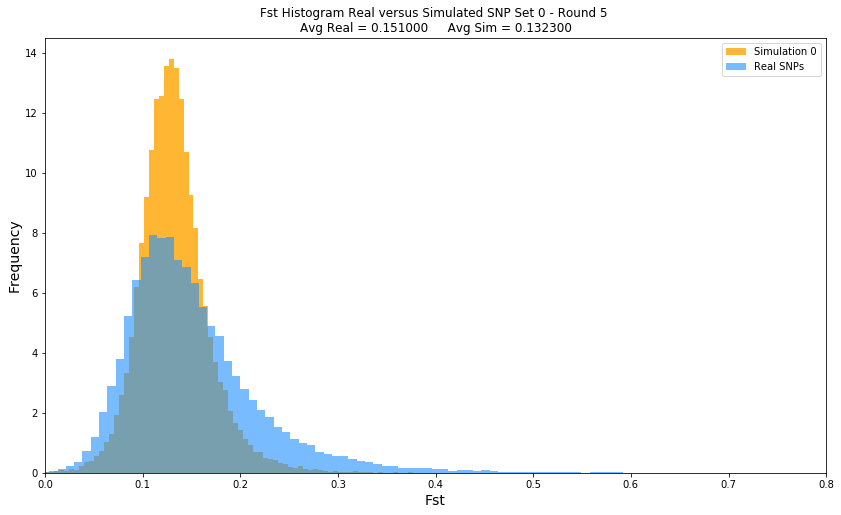

43977 windows are in simulated Fst dataset
Average Fst Real SNPs: 0.151
Median Fst Real SNPs: 0.1376
Average Fst Simulated SNPs: 0.1335
Median Fst Simulated SNPs: 0.1302


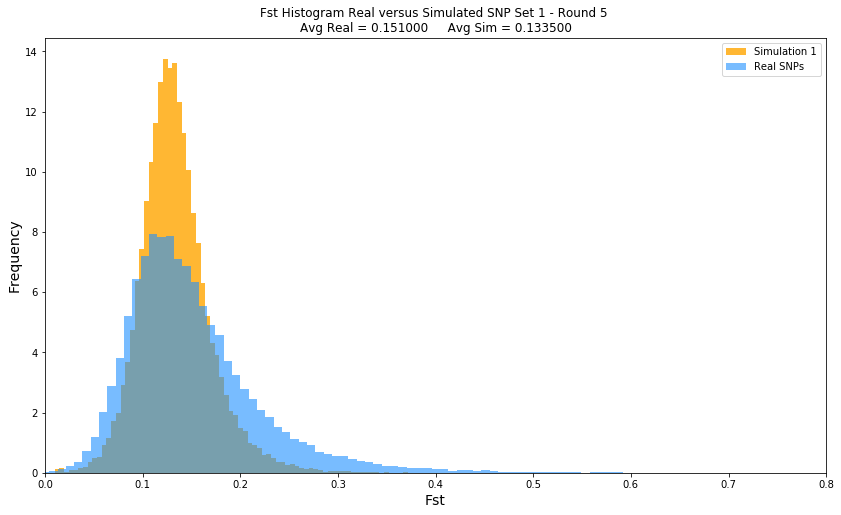

In [100]:
#Plotting the Fst distributions for each snp set per simulation round
simDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Simulations/results/simulation%i/' % simulationRound
for i in range(0,2):
    sim = i
    simFst = [] #clear for each simulation being processed
    
    simFstFile = open(simDir + 'Simulation.%i_Hudson_Fst_200kbWindow_50kbSlide.txt_filtered_windows_RofA_Fst_Zscores.txt' % sim, 'r')
    simFst = process_infile(simFstFile,simFst)
    print('%i windows are in simulated Fst dataset' % len(simFst))

    avg_real, median_real, avg_sim, median_sim = calc_averages(realFst,simFst)
    make_plots(realFst,simFst,i,simDir, avg_real, avg_sim, simulationRound)  
    #break

In [8]:
##############################################################################################################
def draw_Manhattan_Plot(totalData,title, colors):
    df = pd.DataFrame(totalData,columns=['Chromosome','Start','End','WindowID','FST','Z'])
    df.Chromosome = df.Chromosome.astype('category')
    df.Chromosome = df.Chromosome.cat.set_categories(chromToDo, ordered=True)
    df = df.sort_values('Chromosome')

    # How to plot gene vs. -log10(pvalue) and colour it by chromosome?
    df['ind'] = range(len(df))
    df_grouped = df.groupby(('Chromosome'))
    ###PLOTTING MANHATTAN PLOT 
    #plotDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/XP-CLR/results/plots/'
    fig = plt.figure(figsize=(24,12))
    ax = fig.add_subplot(111)
    x_labels, x_labels_pos = [], []
    for num, (name, group) in enumerate(df_grouped):
        group.plot(kind='scatter', x='ind', y='Z',color=colors[num % len(colors)], ax=ax)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
    #Xaxis
    ax.set_xlim([0, len(df)])
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels, fontsize=16)
    ax.set_xlabel('Chromosome',fontsize=20)
    #Yaxis
    ax.set_ylim([0, 8])
    ax.set_ylabel('ZFst',fontsize=20)
    #Tick label sizes
    plt.tick_params(axis='both', which='major', labelsize=16)
    fig.tight_layout(rect=[0,0,.8,1]) 
    plt.hlines(y=5,xmin=0,xmax=len(df), lw=1,color="red", label="Z Threshold")
    legend = ax.legend(loc='upper right', shadow=False,prop={'size': 20})
    plt.title(title,fontsize=30)
    #plt.savefig(plotDir + subDir + '_50kbWindow_2kbGridSize' + '_XP-CLR.png')
##############################################################################################################
##############################################################################################################

43977 windows are in simulated Fst dataset
43977 windows are in simulated Fst dataset


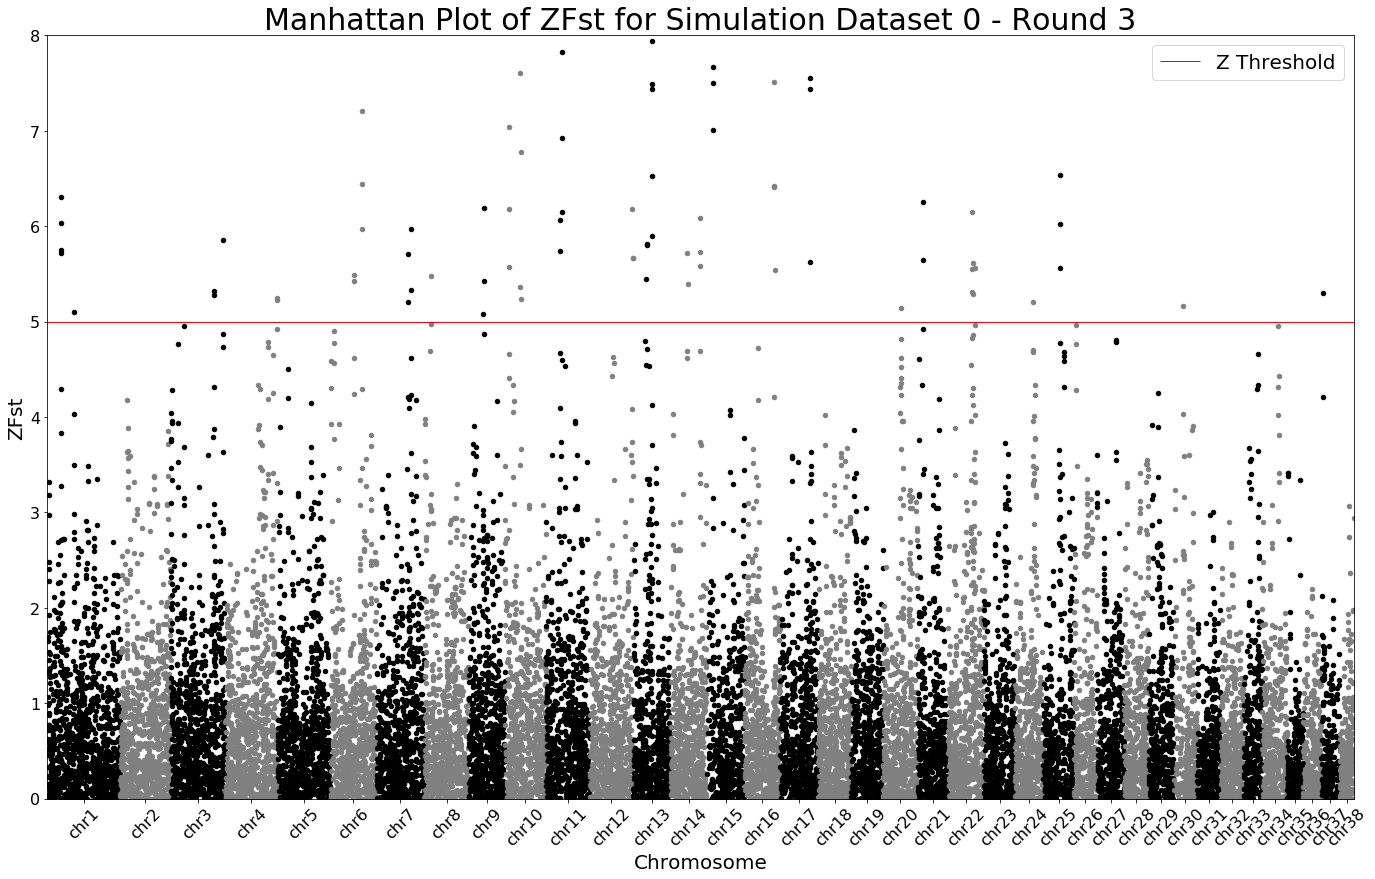

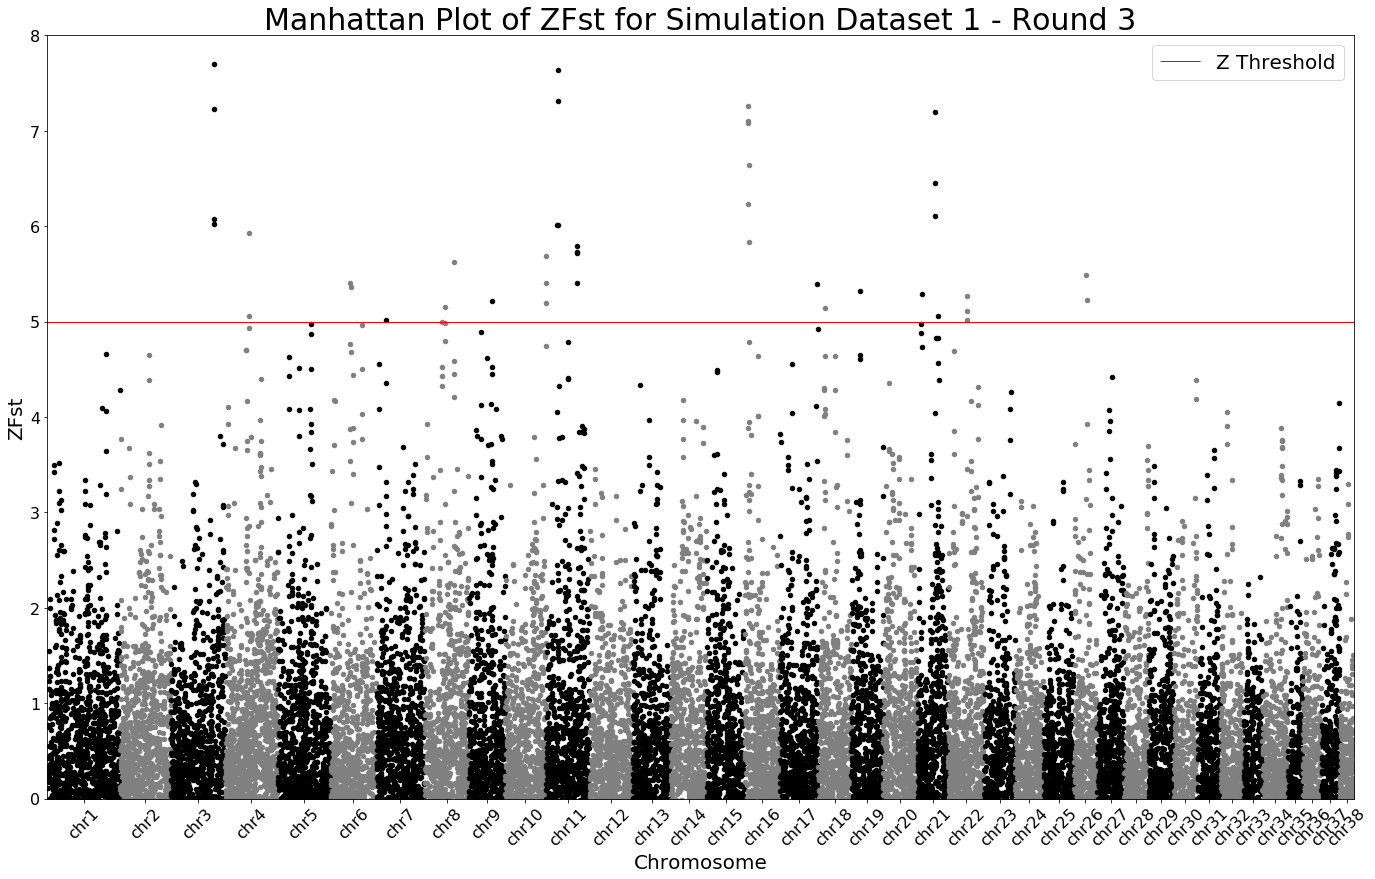

In [14]:
chromToDo = []
for i in range(1,39):
    chrom = 'chr' + str(i)
    chromToDo.append(chrom)

for i in range(0,2):
    sim = i
    totalData = [] #clear for each simulation being processed
    
    simFstFile = open(simDir + 'Simulation.%i_Hudson_Fst_200kbWindow_50kbSlide.txt_filtered_windows_RofA_Fst_Zscores.txt' % sim, 'r')
    for line in simFstFile:
        line=line.rstrip().split()
        if 'CHROM' in line: #skips header
            continue
        c, start, end, window, fst, z = line[0], int(line[1]), int(line[2]),line[3],float(line[7]),float(line[9])
        totalData.append([c, start, end, window, fst, z])
    print('%i windows are in simulated Fst dataset' % len(simFst))
    #For plot
    title = 'Manhattan Plot of ZFst for Simulation Dataset %i - Round %i' % (sim, simulationRound)
    colors = ['black','gray']
    draw_Manhattan_Plot(totalData, title, colors)
    
    #break #for testing after one simulation

In [29]:
###################################################################################################
###################################################################################################
###################################################################################################

43983 windows are in REAL Fst dataset


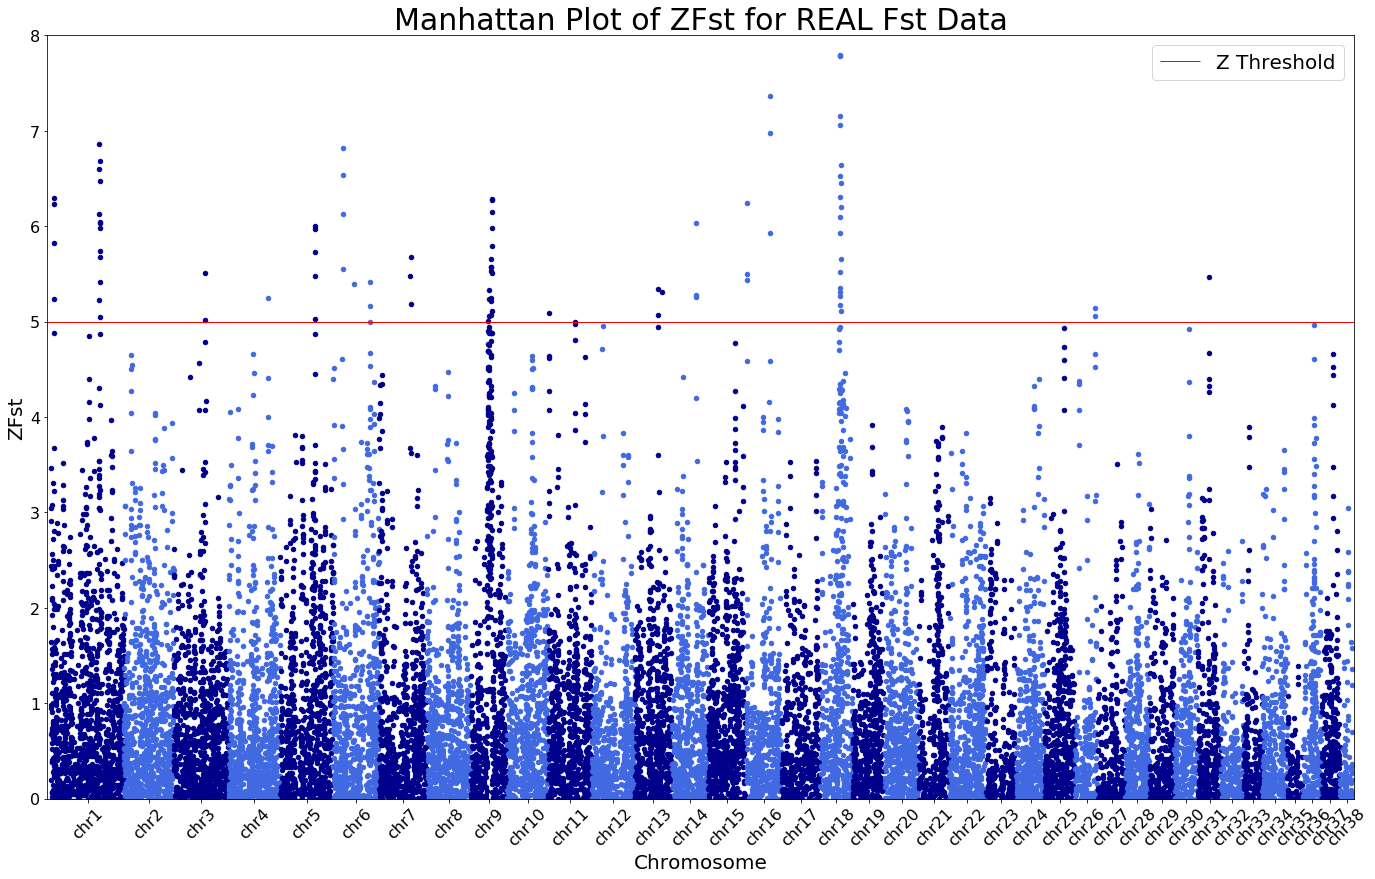

In [44]:

realFstFile = open('/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Total_54callset_MxbRemoved/Sliding/AutoXPar/village_wolf_mxb_rm_54callset_autoXpar_Hudson_Fst_200kbWindow_50kbSlide.txt_filtered_windows_RofA_Fst_Zscores.txt','r')
totalData = []
for line in realFstFile:
    line=line.rstrip().split()
    if 'CHROM' in line: #skips header
        continue
    c, start, end, window, fst, z = line[0], int(line[1]), int(line[2]),line[3],float(line[7]),float(line[9])
    totalData.append([c, start, end, window, fst, z])
print('%i windows are in REAL Fst dataset' % len(totalData))
title = 'Manhattan Plot of ZFst for REAL Fst Data'
colors = ['darkblue','royalblue']
draw_Manhattan_Plot(totalData, title, colors)

#break #for testing after one simulation